# Jina Meme Search Workshop

![](http://examples.jina.ai/images/meme_search.gif)

In this workshop we're going to build a meme search engine using [Jina](https://github.com/jina-ai/jina/). It will search a dataset of memes and return URLs to the images as well as metadata.

For this workshop we'll just focus on searching **text**. For a more complete repo (including text/image search and frontend) you can check [this link](https://github.com/alexcg1/jina-meme-search).

You can play with a live example [here](https://examples.jina.ai).

## Set up basics

In [ ]:
max_docs = 50

## Install Prerequisites

In [ ]:
!cd /
!wget https://raw.githubusercontent.com/jina-ai/workshops/main/memes/requirements.txt -qN
!pip install -r requirements.txt

## Download the dataset

This is an open source dataset from imgflip, originally downloaded from [Kaggle](https://www.kaggle.com/abhishtagatya/imgflipscraped-memes-caption-dataset).

### Why this dataset?

We chose this dataset because

- It has rich metadata (caption, template name)
- It has recognizable memes (many datasets were just random pics with overlaid Impact font)
- It doesn't *seem* to have too many racist/sexist/\*phobic memes 🤞

### Why does this dataset kinda suck?

It only contains so many memes, and new memes come out all the time. So it won't have the latest, dankest stuff.

In [ ]:
!mkdir -p data
!wget -O data/memes.json https://jina-examples-datasets.s3.amazonaws.com/memes/memes.json -N

## Load data

I've written a function to help load the data from the JSON file we downloaded earlier.

In this function we:

- Create a `DocumentArray` to hold `Documents`
- Optionally shuffle the memes
- Create a `Document` for each meme
- Set `Document.text` to the template name (e.g. `"Surprised Koala"`) + meme caption (e.g. `"This is poisonous. What"`)
- Populate some `tags` for the `Document` (e.g. absolute URL for image)

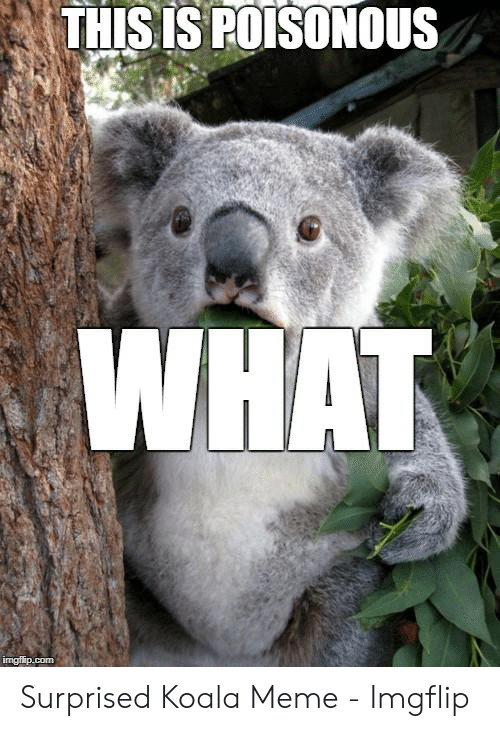

In [ ]:
from jina import Document, DocumentArray

In [ ]:
import json
def prep_docs(input_file, num_docs=None, shuffle=True):
    docs = DocumentArray()
    memes = []
    print(f"Processing {input_file}")
    with open(input_file, "r") as file:
        raw_json = json.loads(file.read())

    for template in raw_json:
        for meme in template["generated_memes"]:
            meme["template"] = template["name"]
        memes.extend(template["generated_memes"])

    if shuffle:
        import random
        random_seed = 1337

        random.seed(random_seed)
        random.shuffle(memes)

    for meme in memes[:num_docs]:
        doctext = f"{meme['template']} - {meme['caption_text']}"
        doc = Document(text=doctext)
        doc.tags = meme
        doc.tags["uri_absolute"] = "http:" + doc.tags["image_url"]
        docs.extend([doc])

    return docs

### Why do we need to shuffle?

The memes are arranged alphabetically by template. So if we don't shuffle we're going to get very similar memes. This makes it more difficult to search for something interesting.

In [ ]:
docs = prep_docs(
    input_file="data/memes.json", 
    num_docs=max_docs, 
    shuffle=False
)

In [ ]:
from IPython.display import Image, display
import os

def show_images(docs, max_images=5):
    for doc in docs[:max_images]:
        url = doc.tags["uri_absolute"]
        !wget {url} -q

        filename = url.split("/")[-1]
        display(Image(filename=filename))
        os.remove(filename)

In [ ]:
show_images(docs)

### If we do shuffle we get a better mix

In [ ]:
docs = prep_docs(
    input_file="data/memes.json", 
    num_docs=max_docs, 
    shuffle=True
)

In [ ]:
show_images(docs)

## Let's actually get a buttload of memes

That's a metric buttload fwiw.

The more memes we have, the better our search results will be.

In [ ]:
docs = prep_docs(
    input_file="data/memes.json",
    num_docs=max_docs,
    shuffle=True
)

## Set up Flow

In [ ]:
from jina import Flow

In [1]:
flow = (
    Flow()
    .add(
        name="meme_text_encoder",
        uses="jinahub://SpacyTextEncoder/v0.2",                 # Using Executors from Jina Hub means we don't need to write our own!
        uses_with={"model_name": "en_core_web_md"},
        install_requirements=True
    )
    .add(
        name="meme_text_indexer",
        uses="jinahub://SimpleIndexer",
    )
)

NameError: name 'Flow' is not defined

## Index data with Flow

In [ ]:
!rm -rf workspace # Remove workspace in case we've indexed stuff before

with flow:
  flow.index(
      inputs=docs,
      request_size=64,
  )

## Search data with Flow

In [ ]:
query_doc = Document(text="school")

In [ ]:
with flow:
  response = flow.search(inputs=query_doc, return_results=True)

In [ ]:
matches = response[0].docs[0].matches

In [ ]:
for doc in matches[:5]:
    url = doc.tags["uri_absolute"]
    !wget {url} -q

    filename = url.split("/")[-1]
    display(Image(filename=filename))
    os.remove(filename)

## Using this IRL

How can we take this out of a notebook and build a real-world application with it?

### Use a RESTful API

#### In notebook: gRPC

```python
with flow:
    flow.search(Document(text="foo"))
```

#### In Python: RESTful or gRPC

```python
with flow:
    flow.protocol = "http"
    flow.port_expose = 12345
    flow.block()
```

### Use Dockerized Executors

This means having to install fewer requirements locally.


#### In notebook: `jinahub://foo`

```python
flow = (
    Flow()
    .add(...)
    .add(
        uses="jinahub://SimpleIndexer",
    )
)
```

#### In Python: `jinahub+docker://foo`

```python
flow = (
    Flow()
    .add(...)
    .add(
        uses="jinahub+docker://SimpleIndexer",
    )
)
```